# Load Packages and Set Global Variables

<a id="imports"></a>

## Imports and Settings

In [1]:
import anndata
import diffxpy.api as de
import numpy as np
import os
import scanpy as sc
import scvelo as scv
import sys
import pandas as pd
import patsy
import pickle
import scipy.stats
import seaborn as sb
import sklearn
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn import svm
import tensorflow as tf
import matplotlib.pyplot as plt

np.random.seed(seed=1)

**Interactive panel:** Set up paths here.

In [2]:
root_dir = '/'

sc.settings.verbosity = 3 # amount of output

root_dir = '.'

dir_in = root_dir + 'data/'
base_dir = root_dir + 'results/'
dir_gene_sets = root_dir + 'data/gene_sets/MSigDBlists/'
dir_cc_gene_set = root_dir + 'data/gene_sets/regev_lab_cell_cycle_genes_10X.txt'

tf_ref_file = dir_gene_sets + 'c3.tft.v5.2.symbols.gmt'
bp_ref_file = dir_gene_sets + 'c5.bp.v5.2.symbols.gmt'
mf_ref_file = dir_gene_sets  + "c5.mf.v5.2.symbols.gmt"
hal_ref_file = dir_gene_sets + 'h.all.v5.2.symbols.gmt'

sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, scanpy=True)
sc.settings.figdir = dir_out
scv.settings.figdir = dir_out
print(sys.version)

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.6
scanpy      1.8.1
sinfo       0.3.4
-----
2f7ece400a652629565c523b34ee61b04afa385c    NA
PIL                                         8.3.2
absl                                        NA
anyio                                       NA
appnope                                     0.1.2
astunparse                                  1.6.3
attr                                        21.2.0
babel                                       2.9.1
backcall                                    0.2.0
batchgl

In [3]:
constructs = [
    "Ascl1_transgene",
    "Hnf1a_transgene",
    "Myod1_transgene",
    "Pou5f1_transgene"
]

constructs_color_dict = {
    "DsRed": ['DsRed-Express-plus', 'DsRed-Express-minus'],
    "AcGFP1": ['AcGFP1-plus', 'AcGFP1-minus'],
    "EBFP2": ['EBFP2-plus', 'EBFP2-minus']
}
constructs_color = [
    "DsRed",
    "AcGFP1",
    "EBFP2"
]
endogenous_genes = [
    "Ascl1",
    "Hnf1a",
    "Myod1",
    "Pou5f1"
]

<a id="Global"></a>

## Global Variables

**Interactive panels:** Define what is recomputed here, leave as is if you want to rely entirely on precomputed objects.


All embeddings and clusterings can be saved and loaded into this script. Be carful with overwriting cluster caches as soon as cell type annotation has started as cluster labels may be shuffled.

Set whether anndata objects are recomputed or loaded from cache.

In [4]:
bool_recomp = True

Set whether to produce plots, set to False for test runs.

In [5]:
bool_plot = True

# Simulate doublets

In [6]:
adata_proc = sc.read(dir_anndata+'adata_proc.h5ad') 

In [7]:
if bool_recomp == True:  
    ncells = 200
    idx0 = np.random.randint(0, np.sum(adata_proc.obs["inferred_category_real"].values == "1) AcGFP1, Ascl1"), ncells)
    idx1 = np.random.randint(0, np.sum(adata_proc.obs["inferred_category_real"].values == "2) AcGFP1, Myod1"), ncells)
    adata_sim = anndata.AnnData(
        X=(
            adata_proc[adata_proc.obs["inferred_category_real"].values == "1) AcGFP1, Ascl1"].X[idx0, :] + \
            adata_proc[adata_proc.obs["inferred_category_real"].values == "2) AcGFP1, Myod1"].X[idx1, :]
        ) / 2.,
        obs=pd.DataFrame({
            "inferred_category_real": "simulated",
            "louvain_named_subclustered": "simulated",
            "Ascl1_transgene": (adata_proc[adata_proc.obs["inferred_category_real"].values == "1) AcGFP1, Ascl1"].obs["Ascl1_transgene"].values[idx0] + \
                adata_proc[adata_proc.obs["inferred_category_real"].values == "2) AcGFP1, Myod1"].obs["Ascl1_transgene"].values[idx1]) / 2.,
            "Myod1_transgene": (adata_proc[adata_proc.obs["inferred_category_real"].values == "1) AcGFP1, Ascl1"].obs["Myod1_transgene"].values[idx0] + \
                adata_proc[adata_proc.obs["inferred_category_real"].values == "2) AcGFP1, Myod1"].obs["Myod1_transgene"].values[idx1]) / 2.,
        }, index=["simulated_cell_" + str(i) for i in range(ncells)])
    )
    adata_sim.var_names = adata_proc.var_names
    adata_sim = adata_sim.concatenate(adata_proc)
    adata_sim.obs["simulated"] = np.asarray(adata_sim.obs["inferred_category_real"].values == "simulated", dtype=int).astype(float)
    adata_sim.obs["real_double_positive"] = np.asarray(adata_sim.obs["inferred_category_real"].values == '5) AcGFP1, DsRed, Ascl1, Myod1', dtype=int).astype(float)
    adata_sim.obs["double_positive"] = [
        "simulated double positive" if x == "simulated" else
        "real double positive" if x == '5) AcGFP1, DsRed, Ascl1, Myod1' else "real other"
        for x in adata_sim.obs["inferred_category_real"].values
    ]
    adata_sim.obs["Ascl1_transgene_log"] = np.log1p(adata_sim.obs["Ascl1_transgene"].values)
    adata_sim.obs["Myod1_transgene"] = np.log1p(adata_sim.obs["Myod1_transgene"].values)
else:
    adata_sim = sc.read(dir_anndata+'adata_sim.h5ad') 

In [8]:
if bool_recomp == True:   
    adata_sim.raw = adata_sim
    sc.pp.normalize_per_cell(adata_sim)
    sc.pp.log1p(adata_sim)
    sc.pp.filter_genes(adata_sim, min_cells=100)
    sc.pp.highly_variable_genes(adata_sim, flavor='cell_ranger', n_top_genes=4000)
    sc.pp.pca(adata_sim, n_comps=50, random_state=0, use_highly_variable=True, svd_solver='arpack')
    sc.pp.neighbors(adata_sim, n_neighbors=100, knn=True, method='umap', n_pcs=50, random_state=0)
    sc.tl.umap(adata_sim)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:17)


... storing 'inferred_category_real' as categorical
... storing 'louvain_named_subclustered' as categorical
... storing 'double_positive' as categorical


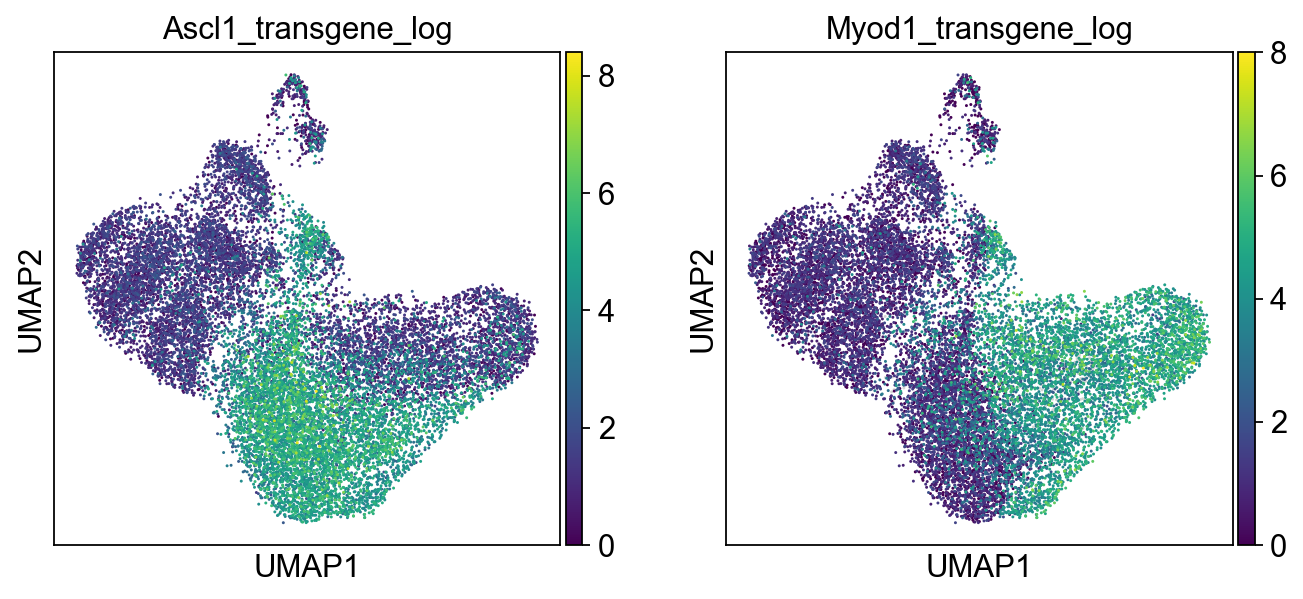

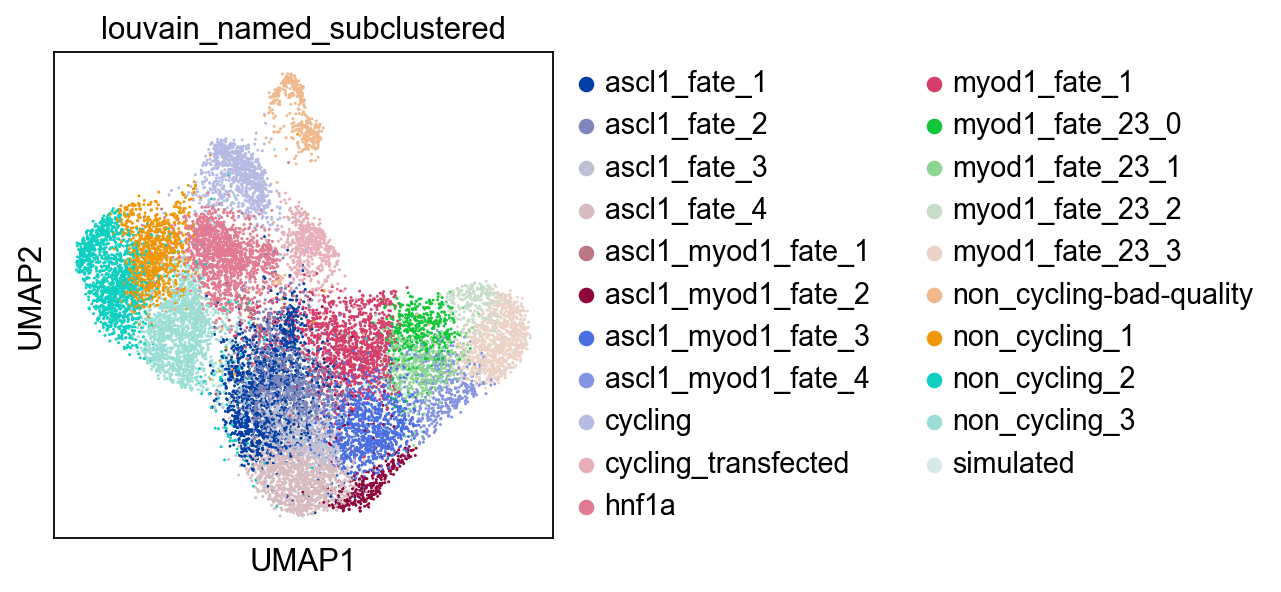

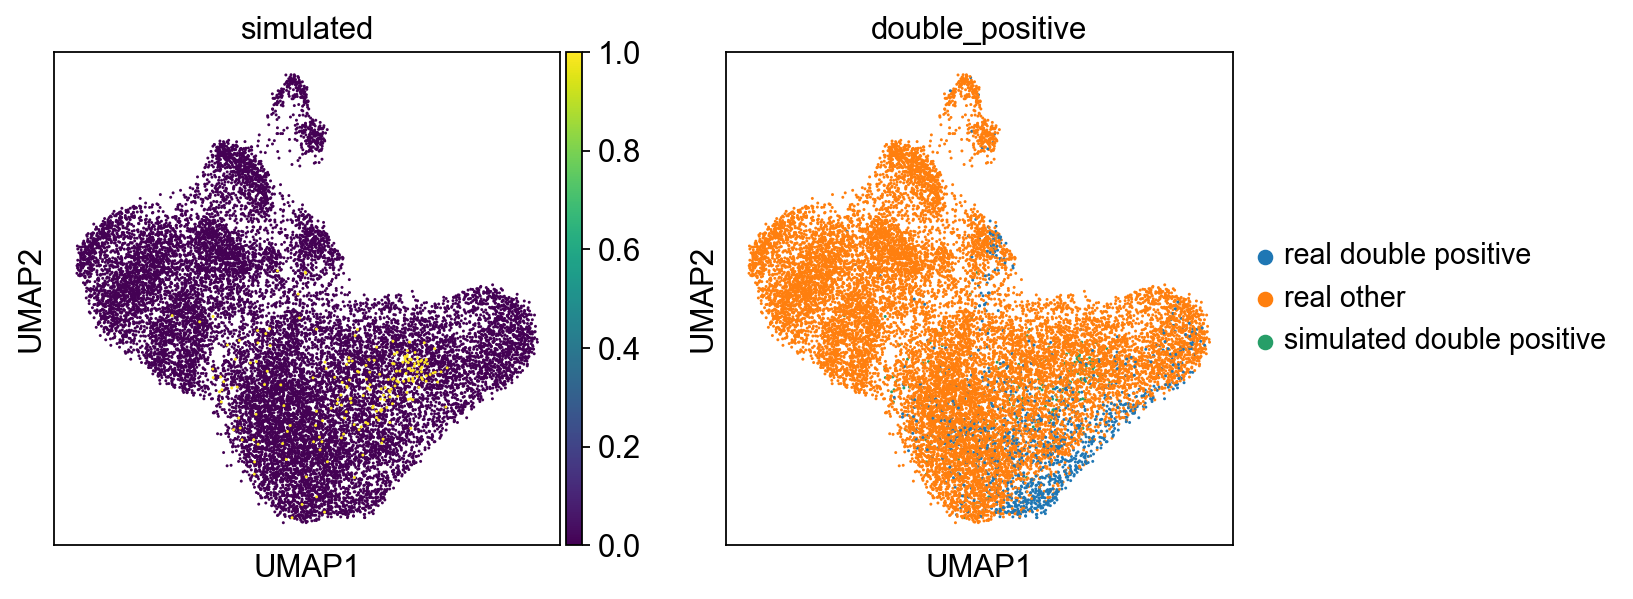

In [9]:
sc.pl.umap(adata_sim, color=["Ascl1_transgene_log", "Myod1_transgene_log"])
sc.pl.umap(adata_sim, color="louvain_named_subclustered")
sc.pl.umap(adata_sim, color=["simulated", "double_positive"])

In [10]:
color_map = {
    "ascl1_fate_1": 'lightblue',
    "ascl1_fate_2": 'royalblue',
    "ascl1_fate_3": 'blue',
    "ascl1_fate_4": 'darkblue', 
    "ascl1_myod1_fate_1":  'lightblue',
    "ascl1_myod1_fate_2": 'teal',
    "ascl1_myod1_fate_3": 'teal', 
    "ascl1_myod1_fate_4":  '#838C00',
    "cycling": 'purple',
    "cycling_transfected": 'royalblue',
    "hnf1a": "#F699CD",
    "myod1_fate_1":'gold',
    "myod1_fate_23_0": '#E59C00',
    "myod1_fate_23_1": '#E59C00',
    "myod1_fate_23_2": 'darkred',
    "myod1_fate_23_3": 'darkorange',
    "non_cycling-bad-quality": '#3A2166',
    "non_cycling_1": 'mediumpurple',
    "non_cycling_2": 'blueviolet',
    "non_cycling_3": 'indigo',
    "simulated": 'black',
}
adata_sim.uns["louvain_named_subclustered_colors"] = [
    color_map[x] for x in adata_sim.obs["louvain_named_subclustered"].values.categories
]

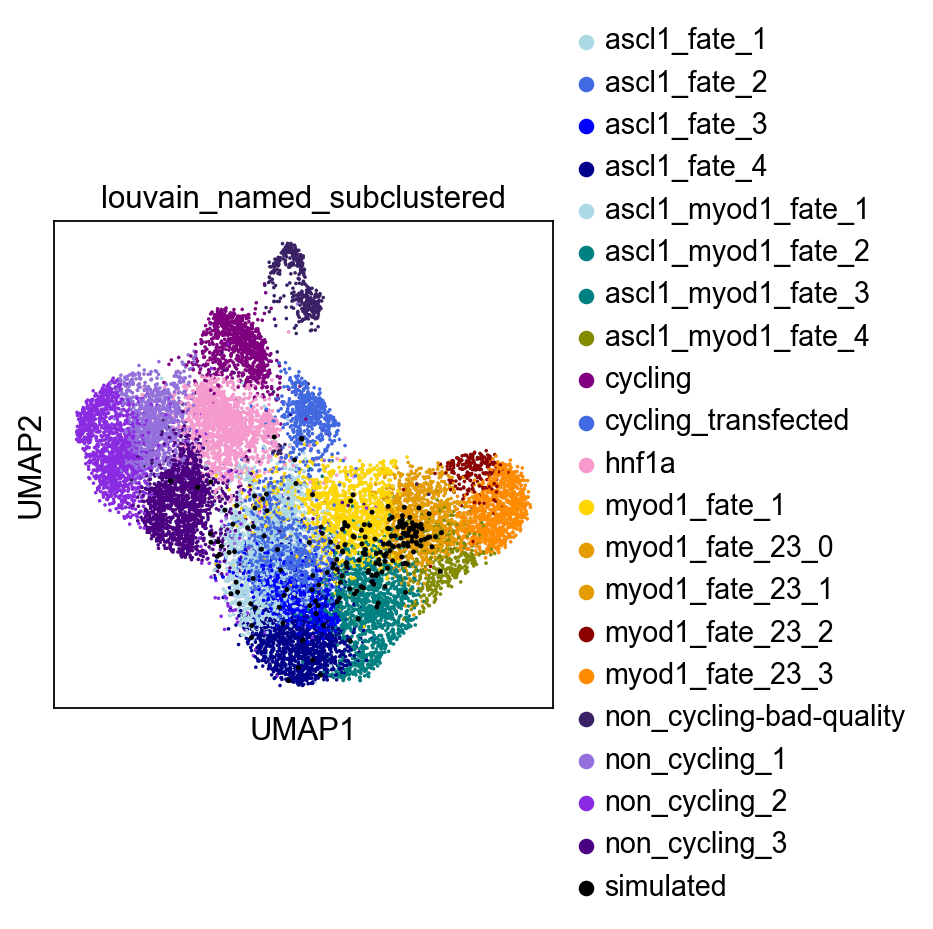

In [11]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,4))
sc.pl.umap(
    adata_sim,
    size=10,
    ax=ax, 
    show=False
)
sc.pl.umap(
    adata_sim[adata_sim.obs["simulated"].values == False], 
    color="louvain_named_subclustered", 
    size=10,
    ax=ax, 
    show=False
)
sc.pl.umap(
    adata_sim[adata_sim.obs["simulated"].values == True], 
    color="louvain_named_subclustered", 
    size=20,
    ax=ax, 
    show=False
)
plt.show()

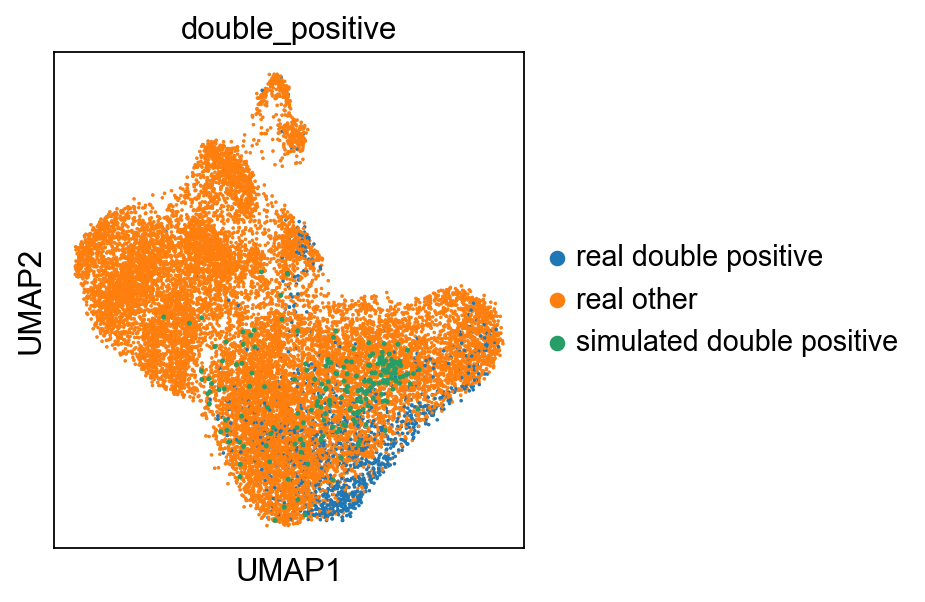

In [16]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 4))
sc.pl.umap(
    adata_sim,
    size=10,
    ax=ax, 
    show=False
)
sc.pl.umap(
    adata_sim[adata_sim.obs["simulated"].values == False], 
    color="double_positive", 
    size=10,
    ax=ax, 
    show=False
)
sc.pl.umap(
    adata_sim[adata_sim.obs["simulated"].values == True], 
    color="double_positive", 
    size=20,
    ax=ax, 
    show=False
)
plt.tight_layout()
plt.savefig(dir_out + "EV3f.pdf", bbox_inches='tight')
plt.show()

Assign condition to simulated cells based on kNN classifier:

In [13]:
nn = adata_sim.uns["neighbors"]["connectivities"]
q = 1.0
louvain_named_subclustered = adata_sim.obs["louvain_named_subclustered"].values
for i, x in enumerate(adata_sim[adata_sim.obs["simulated"].values == True].obs_names):
    j = adata_sim.obs_names.tolist().index(x)
    n = adata_sim.obs["louvain_named_subclustered"].values[np.logical_and(
        np.asarray(nn[j, :].todense() >= np.quantile(nn[j, :][:, adata_sim.obs["simulated"].values == False].todense(), q=q)).flatten(),
        adata_sim.obs["simulated"].values == False
    )]
    (values,counts) = np.unique(n, return_counts=True)
    louvain_named_subclustered[j] = values[np.argmax(counts)]

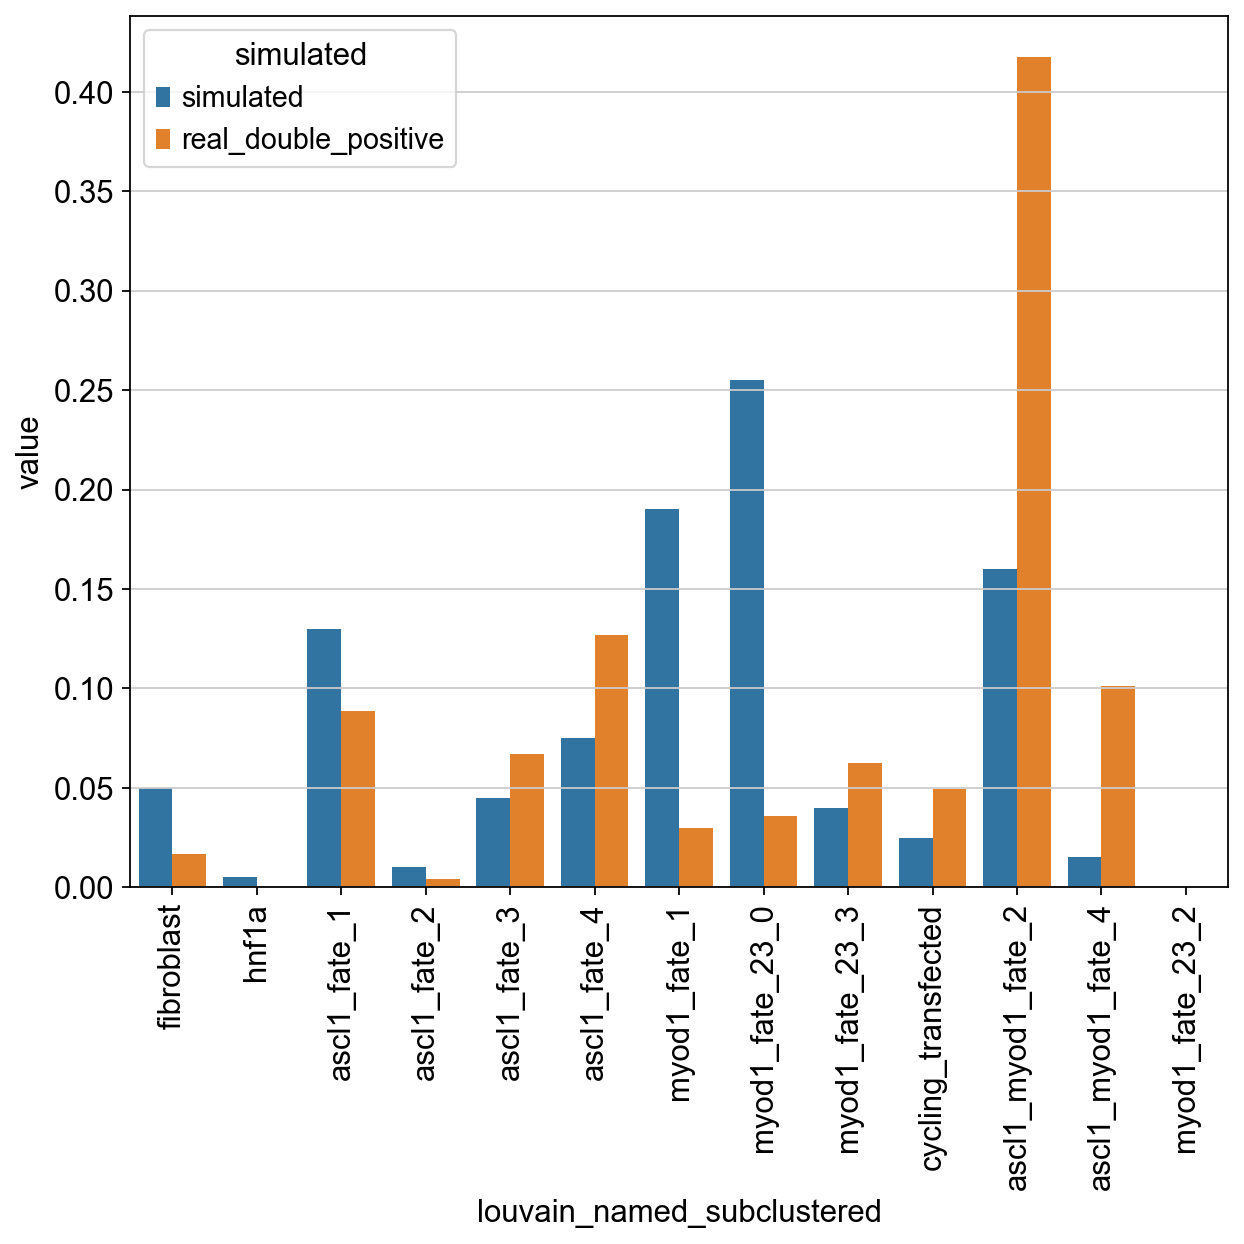

In [17]:
sns_data = adata_sim.obs.copy()
sns_data["louvain_named_subclustered"] = [  # merge fibroblasts
    "fibroblast" if x in ["non_cycling_1", "non_cycling_2", "non_cycling_3", "non_cycling-bad-quality" , "cycling"]
    else x for x in sns_data["louvain_named_subclustered"].values
]
sns_data["louvain_named_subclustered"] = [  # merge myod1_fate_0 and myod1_fate_1
    "myod1_fate_23_0" if x in ["myod1_fate_23_0", "myod1_fate_23_1"]
    else x for x in sns_data["louvain_named_subclustered"].values
]
sns_data["louvain_named_subclustered"] = [  # merge myod1_fate_0 and myod1_fate_1
    "ascl1_myod1_fate_2" if x in ["ascl1_myod1_fate_2", "ascl1_myod1_fate_3"]
    else x for x in sns_data["louvain_named_subclustered"].values
]
sns_data["louvain_named_subclustered"] = [  # merge myod1_fate_0 and myod1_fate_1
    "ascl1_fate_1" if x in ["ascl1_fate_1", "ascl1_myod1_fate_1"]
    else x for x in sns_data["louvain_named_subclustered"].values
]
sns_data = sns_data.groupby("louvain_named_subclustered")[["simulated", "real_double_positive"]].sum().reset_index() 
sns_data.index = sns_data["louvain_named_subclustered"].values
sns_data["simulated"] = sns_data["simulated"].values / np.sum(sns_data["simulated"].values)
sns_data["real_double_positive"] = sns_data["real_double_positive"].values / np.sum(sns_data["real_double_positive"].values)


sns_data = pd.melt(sns_data, id_vars="louvain_named_subclustered", var_name="simulated")
sns_data["louvain_named_subclustered"] = pd.Categorical(
    sns_data["louvain_named_subclustered"].values,
    categories=[
        'fibroblast', 
        'hnf1a',
        'ascl1_fate_1', 
        'ascl1_fate_2', 
        'ascl1_fate_3', 
        'ascl1_fate_4',
        'myod1_fate_1', 
        'myod1_fate_23_0',
        'myod1_fate_23_3',
        'cycling_transfected',
        'ascl1_myod1_fate_2', 
        'ascl1_myod1_fate_4', 
        'myod1_fate_23_2',
    ]
)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
sb.barplot(data=sns_data, x="louvain_named_subclustered", y="value", hue="simulated")
axs.xaxis.set_tick_params(rotation=90)
plt.tight_layout()
plt.savefig(dir_out + "EV3e.pdf")